# Lab 4: Multilingual Subject Enrichment Analysis

## Hypothesis

Identical prompts in different languages (English, German, Tagalog) may have **parallel** (top tokens have the same meaning in respective languages) or even **identical** (top tokens are the same) enriched subject representations in earlier layers of the model.

If there is some kind of **interlingua representation**, the earlier layers of the model might work with an enriched version of the subject regardless of input language, and then internally "translate" it to language-specific representations later on.

## Test Sentences

1. **"Beats Music is owned by"** (Expected: Apple)
2. **"The capital of France is"** (Expected: Paris)

## Methodology

Following Geva et al. (2023) "Dissecting Recall of Factual Associations in Auto-Regressive Language Models":

1. For each layer, take the hidden representation at the **last subject token position**
2. Project it through the final embedding layer to get a distribution over vocabulary
3. Inspect the **top-50 tokens** at each layer
4. Compare all three languages across all layers

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformer_lens import HookedTransformer
import pandas as pd
from collections import defaultdict
import os

os.makedirs("lab4_plots", exist_ok=True)

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 1. Load Model

We use BLOOM-560M (560M parameters, 24 layers), a multilingual model trained on 46 languages including Tagalog and German. This makes it ideal for testing our interlingua hypothesis.

In [2]:
# Load BLOOM-560M (24 layers) - multilingual model trained on 46 languages including Tagalog and German
model = HookedTransformer.from_pretrained("bloom-560m", device=device)

print(f"Model: {model.cfg.model_name}")
print(f"Layers: {model.cfg.n_layers}")
print(f"Hidden dim: {model.cfg.d_model}")
print(f"Vocab size: {model.cfg.d_vocab}")

`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model bloom-560m into HookedTransformer
Model: bloom-560m
Layers: 24
Hidden dim: 1024
Vocab size: 250880


## 2. Define Prompts

We test two factual associations in three languages (English, German, Tagalog):

**Sentence 1: "Beats Music is owned by"**
- Subject: "Beats Music" (last token position = "Music")
- Expected answer: Apple

**Sentence 2: "The capital of France is"**
- Subject: "France"
- Expected answer: Paris

In [3]:
# Define prompts in all three languages

# Sentence 1: Beats Music is owned by
prompts_beats = {
    "English": "Beats Music is owned by",
    "German": "Beats Music gehort",  # "Beats Music is owned by" in German
    "Tagalog": "Ang Beats Music ay pagmamay-ari ng"  # "Beats Music is owned by" in Tagalog
}

# Sentence 2: The capital of France is
prompts_paris = {
    "English": "The capital of France is",
    "German": "Die Hauptstadt von Frankreich ist",  # "The capital of France is" in German
    "Tagalog": "Ang kabisera ng France ay"  # "The capital of France is" in Tagalog
}

# Subject info for each sentence
subjects = {
    "beats": {"token": "Music", "expected": "Apple"},
    "paris": {"token": "France", "expected": "Paris"}
}

print("SENTENCE 1: Beats Music")
for lang, prompt in prompts_beats.items():
    print(f"  {lang}: {prompt}")
print(f"  Expected answer: {subjects['beats']['expected']}")

print("\nSENTENCE 2: Capital of France")
for lang, prompt in prompts_paris.items():
    print(f"  {lang}: {prompt}")
print(f"  Expected answer: {subjects['paris']['expected']}")

SENTENCE 1: Beats Music
  English: Beats Music is owned by
  German: Beats Music gehort
  Tagalog: Ang Beats Music ay pagmamay-ari ng
  Expected answer: Apple

SENTENCE 2: Capital of France
  English: The capital of France is
  German: Die Hauptstadt von Frankreich ist
  Tagalog: Ang kabisera ng France ay
  Expected answer: Paris


In [4]:
# Check what the model actually predicts for each prompt
def get_model_prediction(model, prompt, top_k=5):
    """Get the model's top-k predictions for the next token."""
    tokens = model.to_tokens(prompt)
    logits = model(tokens)  # Shape: [batch, seq, vocab]
    
    # Get logits for the last position (next token prediction)
    last_logits = logits[0, -1, :]  # Shape: [vocab]
    
    # Get top-k predictions
    top = last_logits.topk(top_k)
    top_tokens = model.to_str_tokens(top.indices)
    top_probs = torch.softmax(last_logits, dim=-1)[top.indices].detach().cpu().numpy()
    
    return list(zip(top_tokens, top_probs))

def check_prediction(predictions, expected):
    """Check if expected answer is in top predictions."""
    top_tok = predictions[0][0].strip().lower()
    return "CORRECT" if expected.lower() in top_tok else "WRONG"

print("MODEL PREDICTIONS (Next Token)")
print("=" * 70)

# Sentence 1: Beats Music
print("\n--- SENTENCE 1: Beats Music (Expected: Apple) ---")
for lang, prompt in prompts_beats.items():
    preds = get_model_prediction(model, prompt)
    status = check_prediction(preds, "apple")
    print(f"\n{lang}: \"{prompt}\" ->")
    for tok, prob in preds[:3]:
        print(f"  {tok!r:15} ({prob*100:.1f}%)")
    print(f"  [{status}]")

# Sentence 2: Paris
print("\n--- SENTENCE 2: Capital of France (Expected: Paris) ---")
for lang, prompt in prompts_paris.items():
    preds = get_model_prediction(model, prompt)
    status = check_prediction(preds, "paris")
    print(f"\n{lang}: \"{prompt}\" ->")
    for tok, prob in preds[:3]:
        print(f"  {tok!r:15} ({prob*100:.1f}%)")
    print(f"  [{status}]")

MODEL PREDICTIONS (Next Token)

--- SENTENCE 1: Beats Music (Expected: Apple) ---

English: "Beats Music is owned by" ->
  ' the'          (12.1%)
  ' a'            (4.5%)
  ' The'          (2.1%)
  [WRONG]

German: "Beats Music gehort" ->
  ','             (9.7%)
  '.'             (9.6%)
  ' i'            (2.5%)
  [WRONG]

Tagalog: "Ang Beats Music ay pagmamay-ari ng" ->
  'ay'            (1.9%)
  'ar'            (1.5%)
  'am'            (1.2%)
  [WRONG]

--- SENTENCE 2: Capital of France (Expected: Paris) ---

English: "The capital of France is" ->
  ' Paris'        (22.8%)
  ' the'          (11.6%)
  ' located'      (4.1%)
  [CORRECT]

German: "Die Hauptstadt von Frankreich ist" ->
  '.'             (7.5%)
  ' ein'          (6.9%)
  ' die'          (6.1%)
  [WRONG]

Tagalog: "Ang kabisera ng France ay" ->
  'i'             (8.5%)
  'in'            (2.3%)
  'em'            (1.5%)
  [WRONG]


In [5]:
# Tokenize all prompts
def tokenize_prompts(prompts_dict):
    """Tokenize all prompts and return string tokens."""
    results = {}
    for lang, prompt in prompts_dict.items():
        tokens = model.to_tokens(prompt)
        str_tokens = model.to_str_tokens(prompt)
        results[lang] = {"tokens": tokens, "str_tokens": str_tokens}
    return results

tokens_beats = tokenize_prompts(prompts_beats)
tokens_paris = tokenize_prompts(prompts_paris)

print("SENTENCE 1: Beats Music")
for lang, data in tokens_beats.items():
    print(f"  {lang}: {data['str_tokens']}")

print("\nSENTENCE 2: Capital of France")
for lang, data in tokens_paris.items():
    print(f"  {lang}: {data['str_tokens']}")

SENTENCE 1: Beats Music
  English: ['Be', 'ats', ' Music', ' is', ' owned', ' by']
  German: ['Be', 'ats', ' Music', ' geh', 'ort']
  Tagalog: ['Ang', ' Be', 'ats', ' Music', ' ay', ' pag', 'mam', 'ay', '-', 'ari', ' ng']

SENTENCE 2: Capital of France
  English: ['The', ' capital', ' of', ' France', ' is']
  German: ['Die', ' Haupt', 'stadt', ' von', ' Frankreich', ' ist']
  Tagalog: ['Ang', ' kab', 'isera', ' ng', ' France', ' ay']


In [6]:
# Find subject positions for all prompts
# Note: Subject tokens vary by language (e.g., "France" vs "Frankreich")

def find_subject_position(str_tokens, subject_token):
    """Find the position of the subject token."""
    for i, tok in enumerate(str_tokens):
        if subject_token in tok:
            return i
    # If exact match not found, try case-insensitive
    for i, tok in enumerate(str_tokens):
        if subject_token.lower() in tok.lower():
            return i
    raise ValueError(f"Could not find '{subject_token}' in tokens: {str_tokens}")

# Subject tokens for each sentence - may differ by language
subject_tokens_beats = {
    "English": "Music",
    "German": "Music",
    "Tagalog": "Music"
}

subject_tokens_paris = {
    "English": "France",
    "German": "Frankreich",  # "France" in German
    "Tagalog": "France"
}

# Find positions for Beats Music sentence
subject_pos_beats = {}
for lang, data in tokens_beats.items():
    subject_tok = subject_tokens_beats[lang]
    pos = find_subject_position(data['str_tokens'], subject_tok)
    subject_pos_beats[lang] = pos
    print(f"Beats - {lang} '{subject_tok}' position: {pos} (token: '{data['str_tokens'][pos]}')")

print()

# Find positions for Paris sentence
subject_pos_paris = {}
for lang, data in tokens_paris.items():
    subject_tok = subject_tokens_paris[lang]
    pos = find_subject_position(data['str_tokens'], subject_tok)
    subject_pos_paris[lang] = pos
    print(f"Paris - {lang} '{subject_tok}' position: {pos} (token: '{data['str_tokens'][pos]}')")

Beats - English 'Music' position: 2 (token: ' Music')
Beats - German 'Music' position: 2 (token: ' Music')
Beats - Tagalog 'Music' position: 3 (token: ' Music')

Paris - English 'France' position: 3 (token: ' France')
Paris - German 'Frankreich' position: 4 (token: ' Frankreich')
Paris - Tagalog 'France' position: 4 (token: ' France')


## 3. Extract Hidden Representations and Project to Vocabulary

For each layer, we:
1. Get the residual stream (hidden state) at the subject position
2. Apply layer norm (as done before the final projection)
3. Project through the unembedding matrix to get logits over vocabulary
4. Extract the top-50 tokens

In [7]:
def get_layer_top_tokens(model, prompt, subject_pos, k=50):
    """
    For each layer, extract the hidden representation at subject_pos,
    project to vocabulary space, and return top-k tokens.
    
    Returns:
        dict: layer -> list of (token_str, logit_value) tuples
    """
    tokens = model.to_tokens(prompt)
    
    # Run model and cache all activations
    _, cache = model.run_with_cache(tokens)
    
    results = {}
    
    for layer in range(model.cfg.n_layers):
        # Get residual stream at this layer (after attention + MLP)
        residual = cache[f"blocks.{layer}.hook_resid_post"]
        
        # Get the representation at the subject position
        subject_repr = residual[0, subject_pos, :]  # Shape: [d_model]
        
        # Project to vocabulary space:
        # 1. Apply final layer norm
        # 2. Apply unembedding matrix
        normalized = model.ln_final(subject_repr.unsqueeze(0).unsqueeze(0))
        logits = model.unembed(normalized)  # Shape: [1, 1, vocab_size]
        logits = logits[0, 0, :]  # Shape: [vocab_size]
        
        # Get top-k tokens
        top_k = logits.topk(k)
        top_tokens = model.to_str_tokens(top_k.indices)
        top_values = top_k.values.detach().cpu().numpy()
        
        results[layer] = list(zip(top_tokens, top_values))
    
    return results

In [8]:
# Extract top tokens for all prompts in all languages

def extract_all_layer_tokens(prompts_dict, subject_pos_dict, k=50):
    """Extract layer-wise top tokens for all languages."""
    results = {}
    for lang, prompt in prompts_dict.items():
        print(f"  Extracting for {lang}...")
        results[lang] = get_layer_top_tokens(model, prompt, subject_pos_dict[lang], k=k)
    return results

print("Extracting top tokens for BEATS MUSIC sentence...")
layer_tokens_beats = extract_all_layer_tokens(prompts_beats, subject_pos_beats, k=50)

print("\nExtracting top tokens for CAPITAL OF FRANCE sentence...")
layer_tokens_paris = extract_all_layer_tokens(prompts_paris, subject_pos_paris, k=50)

print("\nDone!")

Extracting top tokens for BEATS MUSIC sentence...
  Extracting for English...
  Extracting for German...
  Extracting for Tagalog...

Extracting top tokens for CAPITAL OF FRANCE sentence...
  Extracting for English...
  Extracting for German...
  Extracting for Tagalog...

Done!


## 4. Visualize Subject Enrichment Across Layers

Let's look at what tokens appear at each layer for both English and Tagalog.

In [9]:
# Display top-10 tokens at selected layers for all languages

def display_layer_comparison(layer_tokens_dict, sentence_name, selected_layers=None):
    """Display top tokens at selected layers for all languages."""
    if selected_layers is None:
        selected_layers = list(range(model.cfg.n_layers))
    
    languages = list(layer_tokens_dict.keys())
    
    print("=" * 100)
    print(f"TOP-10 TOKENS BY SUBJECT REPRESENTATION: {sentence_name}")
    print("=" * 100)
    
    for layer in selected_layers:
        print(f"\nLayer {layer}:")
        
        # Get top-10 for each language
        top10_by_lang = {}
        for lang in languages:
            top10_by_lang[lang] = [t[0] for t in layer_tokens_dict[lang][layer][:10]]
            print(f"  {lang}: {top10_by_lang[lang]}")
        
        # Calculate pairwise overlaps
        for i, lang1 in enumerate(languages):
            for lang2 in languages[i+1:]:
                overlap = set(top10_by_lang[lang1]).intersection(set(top10_by_lang[lang2]))
                print(f"  {lang1}-{lang2} overlap: {len(overlap)} tokens")

# Display for both sentences
display_layer_comparison(layer_tokens_beats, "BEATS MUSIC")
print("\n\n")
display_layer_comparison(layer_tokens_paris, "CAPITAL OF FRANCE")

TOP-10 TOKENS BY SUBJECT REPRESENTATION: BEATS MUSIC

Layer 0:
  English: [' Music', ' music', 'Music', 'music', ' musique', 'usic', ' música', ' Música', ' musicale', ' musical']
  German: [' Music', ' music', 'Music', 'music', ' musique', 'usic', ' música', ' Música', ' musicale', ' musical']
  Tagalog: [' Music', ' music', 'Music', 'music', ' musique', 'usic', ' música', ' Música', ' musicale', '音乐']
  English-German overlap: 10 tokens
  English-Tagalog overlap: 9 tokens
  German-Tagalog overlap: 9 tokens

Layer 1:
  English: [' Music', ' music', 'Music', ' musique', 'music', ' música', ' musicale', ' Música', 'usic', ' musical']
  German: [' Music', ' music', 'Music', ' musique', 'music', ' música', ' musicale', ' Música', 'usic', ' musical']
  Tagalog: [' Music', ' music', 'Music', ' musique', 'music', ' música', ' musicale', ' Música', 'usic', ' musical']
  English-German overlap: 10 tokens
  English-Tagalog overlap: 10 tokens
  German-Tagalog overlap: 10 tokens

Layer 2:
  Engli

In [10]:
# Calculate token overlap at each layer for all language pairs
def calculate_pairwise_overlaps(layer_tokens_dict, k=50):
    """
    Calculate pairwise overlap metrics between all languages.
    """
    languages = list(layer_tokens_dict.keys())
    n_layers = len(layer_tokens_dict[languages[0]])
    
    results = {}
    
    for i, lang1 in enumerate(languages):
        for lang2 in languages[i+1:]:
            pair_name = f"{lang1}-{lang2}"
            overlaps = []
            jaccard = []
            
            for layer in range(n_layers):
                set1 = set([t[0] for t in layer_tokens_dict[lang1][layer][:k]])
                set2 = set([t[0] for t in layer_tokens_dict[lang2][layer][:k]])
                
                intersection = len(set1.intersection(set2))
                union = len(set1.union(set2))
                
                overlaps.append(intersection)
                jaccard.append(intersection / union if union > 0 else 0)
            
            results[pair_name] = {
                'overlaps': np.array(overlaps),
                'jaccard': np.array(jaccard)
            }
    
    return results

# Calculate for both sentences
overlap_beats = calculate_pairwise_overlaps(layer_tokens_beats, k=50)
overlap_paris = calculate_pairwise_overlaps(layer_tokens_paris, k=50)

# Debug: Show sample tokens at layer 0 to verify data is different per language
print("DEBUG - Layer 0 top-5 tokens for BEATS MUSIC:")
for lang in layer_tokens_beats.keys():
    tokens = [t[0] for t in layer_tokens_beats[lang][0][:5]]
    print(f"  {lang}: {tokens}")

print("\nDEBUG - Layer 0 top-5 tokens for CAPITAL OF FRANCE:")
for lang in layer_tokens_paris.keys():
    tokens = [t[0] for t in layer_tokens_paris[lang][0][:5]]
    print(f"  {lang}: {tokens}")

print("\n" + "="*60)
print("BEATS MUSIC - Average overlaps (top-50):")
for pair, data in overlap_beats.items():
    print(f"  {pair}: {data['overlaps'].mean():.1f} tokens, Jaccard: {data['jaccard'].mean():.3f}")

print("\nCAPITAL OF FRANCE - Average overlaps (top-50):")
for pair, data in overlap_paris.items():
    print(f"  {pair}: {data['overlaps'].mean():.1f} tokens, Jaccard: {data['jaccard'].mean():.3f}")

DEBUG - Layer 0 top-5 tokens for BEATS MUSIC:
  English: [' Music', ' music', 'Music', 'music', ' musique']
  German: [' Music', ' music', 'Music', 'music', ' musique']
  Tagalog: [' Music', ' music', 'Music', 'music', ' musique']

DEBUG - Layer 0 top-5 tokens for CAPITAL OF FRANCE:
  English: [' France', 'France', ' france', ' Francia', ' França']
  German: [' Frankreich', ' deutschen', ' französis', ' einem', ' einer']
  Tagalog: [' France', 'France', ' france', ' Francia', ' França']

BEATS MUSIC - Average overlaps (top-50):
  English-German: 50.0 tokens, Jaccard: 1.000
  English-Tagalog: 37.2 tokens, Jaccard: 0.604
  German-Tagalog: 37.2 tokens, Jaccard: 0.604

CAPITAL OF FRANCE - Average overlaps (top-50):
  English-German: 4.3 tokens, Jaccard: 0.046
  English-Tagalog: 14.5 tokens, Jaccard: 0.196
  German-Tagalog: 5.0 tokens, Jaccard: 0.059


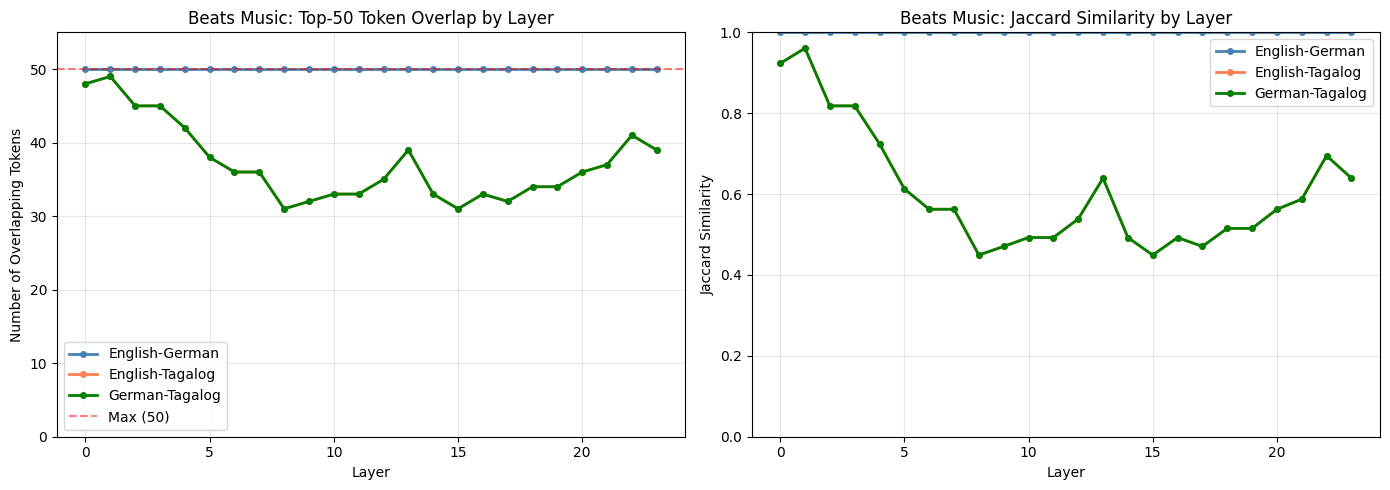

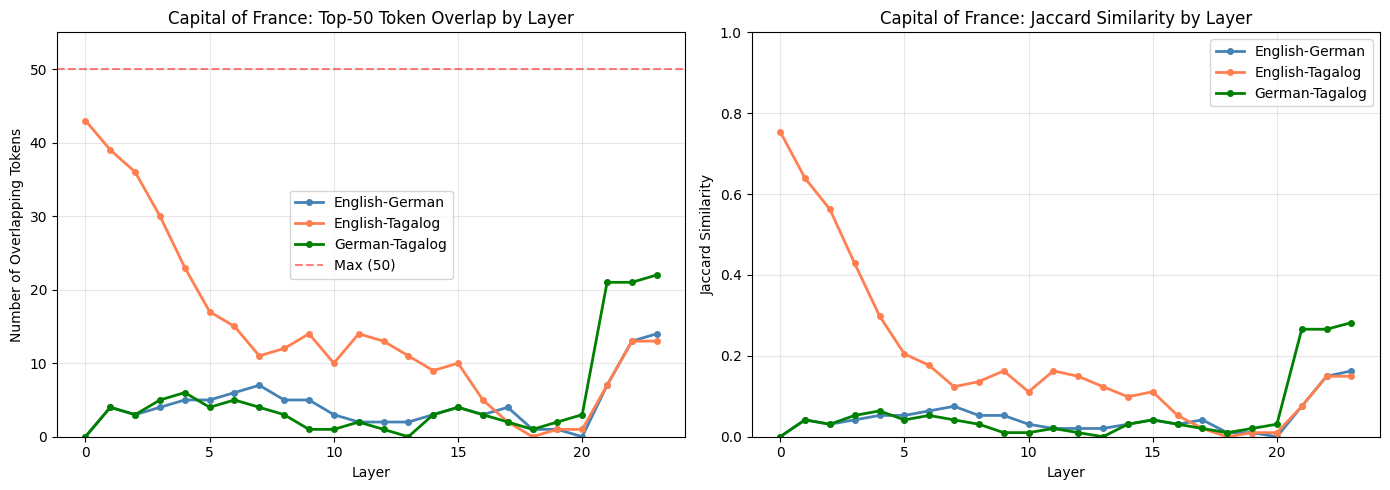

In [11]:
# Plot overlap across layers for all language pairs

def plot_overlaps(overlap_dict, sentence_name, filename_prefix):
    """Plot overlap metrics for all language pairs."""
    colors = ['steelblue', 'coral', 'green']
    n_layers = len(list(overlap_dict.values())[0]['overlaps'])
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Overlap count
    for i, (pair, data) in enumerate(overlap_dict.items()):
        axes[0].plot(range(n_layers), data['overlaps'], 'o-', color=colors[i], 
                     linewidth=2, markersize=4, label=pair)
    axes[0].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='Max (50)')
    axes[0].set_xlabel('Layer')
    axes[0].set_ylabel('Number of Overlapping Tokens')
    axes[0].set_title(f'{sentence_name}: Top-50 Token Overlap by Layer')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim(0, 55)
    
    # Jaccard similarity
    for i, (pair, data) in enumerate(overlap_dict.items()):
        axes[1].plot(range(n_layers), data['jaccard'], 'o-', color=colors[i], 
                     linewidth=2, markersize=4, label=pair)
    axes[1].set_xlabel('Layer')
    axes[1].set_ylabel('Jaccard Similarity')
    axes[1].set_title(f'{sentence_name}: Jaccard Similarity by Layer')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig(f'lab4_plots/{filename_prefix}_overlap.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_overlaps(overlap_beats, "Beats Music", "beats")
plot_overlaps(overlap_paris, "Capital of France", "paris")

## 5. Analyze Semantic Content of Enrichment

Let's look at what concepts appear in the enriched representations. Are they related to "Beats Music" and "Apple"?

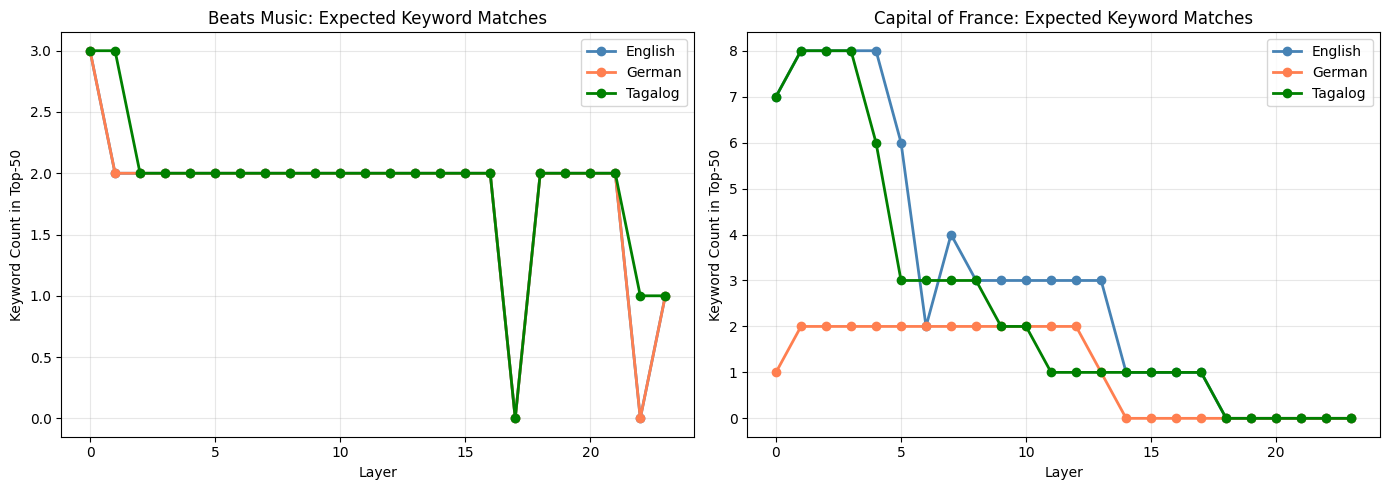

In [12]:
# Keywords we expect to see for each sentence
keywords_beats = [
    'Apple', 'apple', 'iPod', 'iPhone', 'iTunes', 'music', 'Music',
    'streaming', 'audio', 'headphones', 'Beats', 'beats',
    'technology', 'Tech', 'company', 'acquired', 'owned',
    'Spotify', 'Amazon', 'Google', 'Microsoft',  # competitors
    'billion', 'acquisition', 'purchased', 'bought'
]

keywords_paris = [
    'Paris', 'paris', 'France', 'french', 'French', 'Eiffel',
    'capital', 'city', 'Europe', 'European', 'Frankreich',
    'capitale', 'ville', 'French', 'francais', 'kabisera'
]

def count_expected_keywords(layer_tokens_dict, keywords, top_k=50):
    """Count how many expected keywords appear in top-k tokens at each layer for each language."""
    languages = list(layer_tokens_dict.keys())
    n_layers = len(layer_tokens_dict[languages[0]])
    
    results = {}
    for lang in languages:
        counts = []
        for layer in range(n_layers):
            top_tokens = [t[0].strip() for t in layer_tokens_dict[lang][layer][:top_k]]
            count = sum(1 for kw in keywords if any(kw.lower() in tok.lower() for tok in top_tokens))
            counts.append(count)
        results[lang] = np.array(counts)
    return results

keyword_counts_beats = count_expected_keywords(layer_tokens_beats, keywords_beats)
keyword_counts_paris = count_expected_keywords(layer_tokens_paris, keywords_paris)

# Plot keyword enrichment for both sentences
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = {'English': 'steelblue', 'German': 'coral', 'Tagalog': 'green'}

# Beats Music
for lang, counts in keyword_counts_beats.items():
    axes[0].plot(range(model.cfg.n_layers), counts, 'o-', label=lang, 
                 color=colors[lang], linewidth=2)
axes[0].set_xlabel('Layer')
axes[0].set_ylabel('Keyword Count in Top-50')
axes[0].set_title('Beats Music: Expected Keyword Matches')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Paris
for lang, counts in keyword_counts_paris.items():
    axes[1].plot(range(model.cfg.n_layers), counts, 'o-', label=lang, 
                 color=colors[lang], linewidth=2)
axes[1].set_xlabel('Layer')
axes[1].set_ylabel('Keyword Count in Top-50')
axes[1].set_title('Capital of France: Expected Keyword Matches')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lab4_plots/keyword_enrichment.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Detailed Layer-by-Layer Comparison

Let's create a comprehensive view of what tokens appear at each layer.

In [13]:
# Create a DataFrame showing common and unique tokens at each layer
def analyze_layer_tokens_multilang(layer_tokens_dict, layers_to_show=None):
    """Analyze token overlap at specific layers for multiple languages."""
    languages = list(layer_tokens_dict.keys())
    n_layers = len(layer_tokens_dict[languages[0]])
    
    if layers_to_show is None:
        layers_to_show = list(range(n_layers))
    
    results = []
    
    for layer in layers_to_show:
        sets = {lang: set([t[0] for t in layer_tokens_dict[lang][layer][:50]]) for lang in languages}
        
        # Find tokens common to ALL languages
        all_common = sets[languages[0]]
        for lang in languages[1:]:
            all_common = all_common.intersection(sets[lang])
        
        results.append({
            'layer': layer,
            'all_common_count': len(all_common),
            'all_common_sample': list(all_common)[:8]
        })
    
    return pd.DataFrame(results)

# Analyze both sentences
print("BEATS MUSIC - Tokens common to ALL three languages:")
analysis_beats = analyze_layer_tokens_multilang(layer_tokens_beats)
print(analysis_beats[['layer', 'all_common_count']].to_string(index=False))

print("\nCAPITAL OF FRANCE - Tokens common to ALL three languages:")
analysis_paris = analyze_layer_tokens_multilang(layer_tokens_paris)
print(analysis_paris[['layer', 'all_common_count']].to_string(index=False))

BEATS MUSIC - Tokens common to ALL three languages:
 layer  all_common_count
     0                48
     1                49
     2                45
     3                45
     4                42
     5                38
     6                36
     7                36
     8                31
     9                32
    10                33
    11                33
    12                35
    13                39
    14                33
    15                31
    16                33
    17                32
    18                34
    19                34
    20                36
    21                37
    22                41
    23                39

CAPITAL OF FRANCE - Tokens common to ALL three languages:
 layer  all_common_count
     0                 0
     1                 4
     2                 3
     3                 3
     4                 4
     5                 4
     6                 4
     7                 3
     8                 2
     9        

In [14]:
# Show common tokens at key layers for both sentences
key_layers = [0, model.cfg.n_layers//4, model.cfg.n_layers//2, model.cfg.n_layers-1]

for layer in key_layers:
    print(f"\n{'='*80}")
    print(f"LAYER {layer}")
    print(f"{'='*80}")
    
    # Beats Music
    beats_row = analysis_beats[analysis_beats['layer'] == layer]
    if not beats_row.empty:
        print(f"\nBEATS MUSIC - Common to all languages: {beats_row.iloc[0]['all_common_sample']}")
    
    # Paris
    paris_row = analysis_paris[analysis_paris['layer'] == layer]
    if not paris_row.empty:
        print(f"CAPITAL OF FRANCE - Common to all languages: {paris_row.iloc[0]['all_common_sample']}")


LAYER 0

BEATS MUSIC - Common to all languages: [' conciertos', '音乐', ' guitar', 'Música', ' músico', ' Records', ' chanson', ' audio']
CAPITAL OF FRANCE - Common to all languages: []

LAYER 6

BEATS MUSIC - Common to all languages: ['irika', 'mus', 'roads', 'untains', ' Música', "''''", 'Music', 'music']
CAPITAL OF FRANCE - Common to all languages: [' France', 'chaft', ' Francia', ' Frankreich']

LAYER 12

BEATS MUSIC - Common to all languages: ['irika', ' Nashville', 'wane', 'untains', 'ubiri', "''''", 'music', '\xa0(']
CAPITAL OF FRANCE - Common to all languages: []

LAYER 23

BEATS MUSIC - Common to all languages: ['.\n', ' Store', ' Library', ':', ' by', ' Blog', ' |', ' in']
CAPITAL OF FRANCE - Common to all languages: ['.\n', ' -', ' (', '\n', '.\n\n', ':', ' –', '.']


## 7. Test the Interlingua Hypothesis

If there's an interlingua representation, we'd expect:
1. **Early layers**: High overlap (shared processing)
2. **Middle layers**: Divergence begins (language-specific processing)
3. **Late layers**: Possible reconvergence OR continued divergence

Let's test this by looking at the rate of change in overlap.

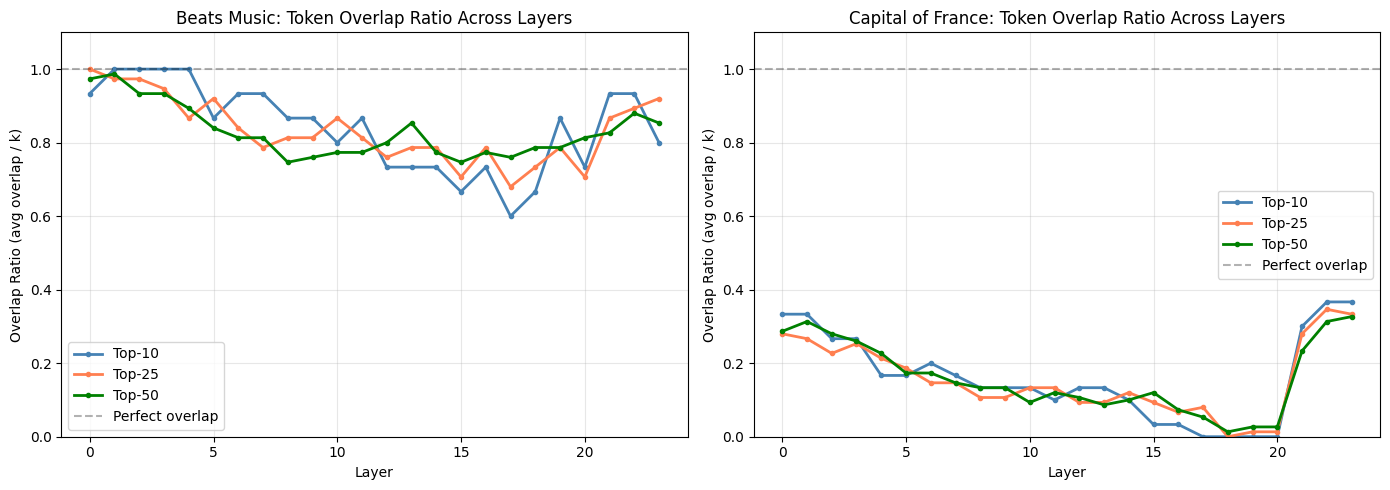

In [15]:
# Compute overlap for different k values to see if pattern holds
k_values = [10, 25, 50]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors_k = ['steelblue', 'coral', 'green']

# For Beats Music (using English-German pair as example)
ax = axes[0]
for i, k in enumerate(k_values):
    overlaps_k = calculate_pairwise_overlaps(layer_tokens_beats, k=k)
    # Average across all pairs
    avg_overlap = np.mean([data['overlaps'] for data in overlaps_k.values()], axis=0)
    overlap_ratio = avg_overlap / k
    ax.plot(range(model.cfg.n_layers), overlap_ratio, 'o-', label=f'Top-{k}', 
            linewidth=2, markersize=3, color=colors_k[i])
ax.axhline(y=1.0, color='black', linestyle='--', alpha=0.3, label='Perfect overlap')
ax.set_xlabel('Layer')
ax.set_ylabel('Overlap Ratio (avg overlap / k)')
ax.set_title('Beats Music: Token Overlap Ratio Across Layers')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.1)

# For Paris
ax = axes[1]
for i, k in enumerate(k_values):
    overlaps_k = calculate_pairwise_overlaps(layer_tokens_paris, k=k)
    avg_overlap = np.mean([data['overlaps'] for data in overlaps_k.values()], axis=0)
    overlap_ratio = avg_overlap / k
    ax.plot(range(model.cfg.n_layers), overlap_ratio, 'o-', label=f'Top-{k}', 
            linewidth=2, markersize=3, color=colors_k[i])
ax.axhline(y=1.0, color='black', linestyle='--', alpha=0.3, label='Perfect overlap')
ax.set_xlabel('Layer')
ax.set_ylabel('Overlap Ratio (avg overlap / k)')
ax.set_title('Capital of France: Token Overlap Ratio Across Layers')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.savefig('lab4_plots/overlap_ratio_by_k.png', dpi=150, bbox_inches='tight')
plt.show()

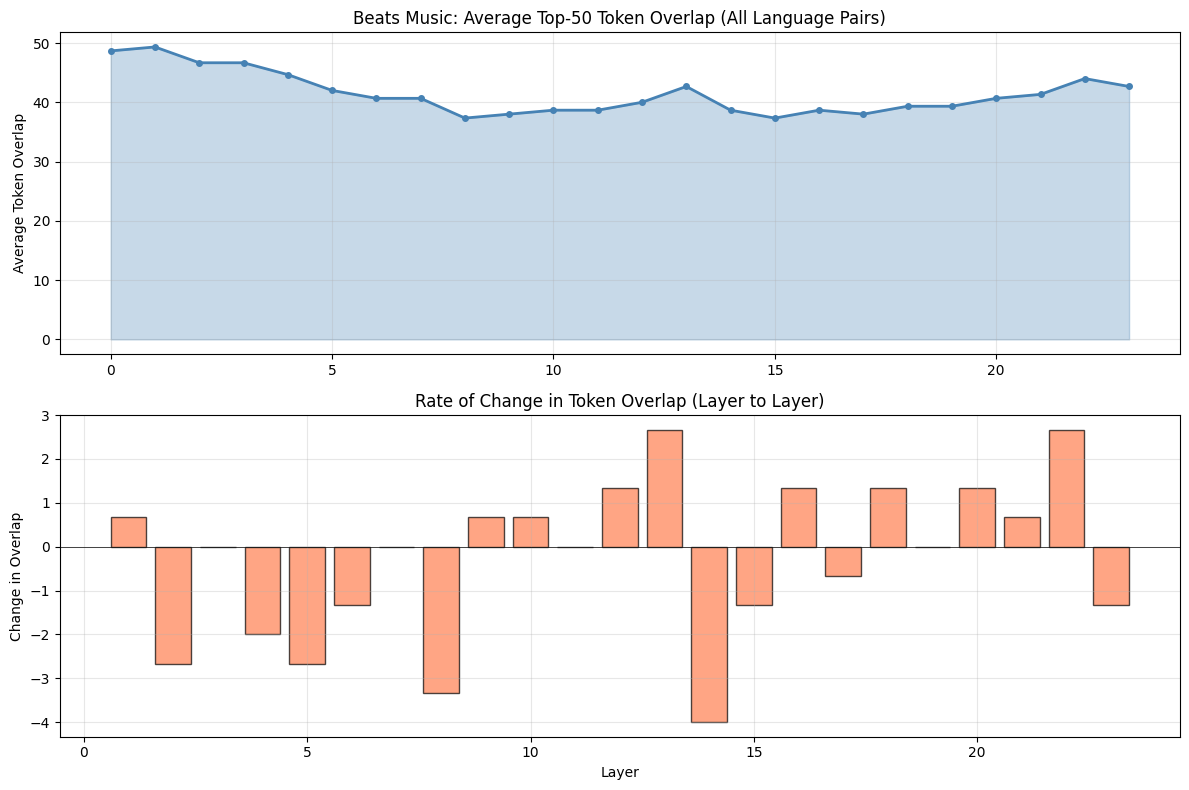


Beats Music Phase Analysis:
  Early layers (0-7) average overlap: 44.9
  Middle layers (8-15) average overlap: 38.9
  Late layers (16-23) average overlap: 40.5


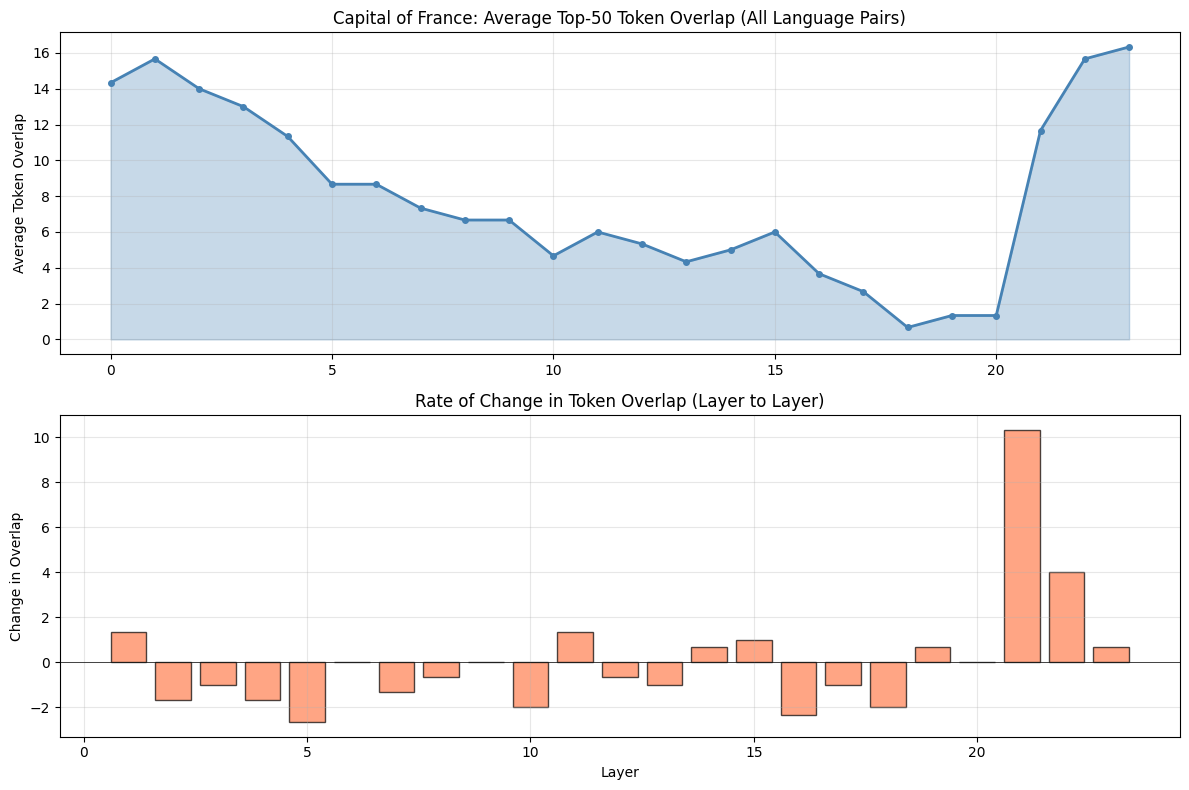


Capital of France Phase Analysis:
  Early layers (0-7) average overlap: 11.6
  Middle layers (8-15) average overlap: 5.6
  Late layers (16-23) average overlap: 6.7


In [16]:
# Phase analysis for both sentences
def phase_analysis(overlap_dict, sentence_name):
    """Analyze phases in overlap pattern."""
    # Average overlaps across all language pairs
    avg_overlaps = np.mean([data['overlaps'] for data in overlap_dict.values()], axis=0)
    n_layers = len(avg_overlaps)
    
    overlap_diff = np.diff(avg_overlaps)
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # Overlap
    axes[0].plot(range(n_layers), avg_overlaps, "o-", color="steelblue", linewidth=2, markersize=4)
    axes[0].fill_between(range(n_layers), avg_overlaps, alpha=0.3, color="steelblue")
    axes[0].set_ylabel("Average Token Overlap")
    axes[0].set_title(f"{sentence_name}: Average Top-50 Token Overlap (All Language Pairs)")
    axes[0].grid(True, alpha=0.3)
    
    # Rate of change
    axes[1].bar(range(1, n_layers), overlap_diff, color="coral", alpha=0.7, edgecolor="black")
    axes[1].axhline(y=0, color="black", linestyle="-", linewidth=0.5)
    axes[1].set_xlabel("Layer")
    axes[1].set_ylabel("Change in Overlap")
    axes[1].set_title("Rate of Change in Token Overlap (Layer to Layer)")
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"lab4_plots/{sentence_name.lower().replace(' ', '_')}_phase.png", dpi=150, bbox_inches="tight")
    plt.show()
    
    # Phase statistics
    third = n_layers // 3
    print(f"\n{sentence_name} Phase Analysis:")
    print(f"  Early layers (0-{third-1}) average overlap: {avg_overlaps[:third].mean():.1f}")
    print(f"  Middle layers ({third}-{2*third-1}) average overlap: {avg_overlaps[third:2*third].mean():.1f}")
    print(f"  Late layers ({2*third}-{n_layers-1}) average overlap: {avg_overlaps[2*third:].mean():.1f}")
    
    return avg_overlaps

avg_overlaps_beats = phase_analysis(overlap_beats, "Beats Music")
avg_overlaps_paris = phase_analysis(overlap_paris, "Capital of France")

## 8. Summary and Conclusions

In [17]:
# Generate summary statistics
print("=" * 80)
print("EXPERIMENT SUMMARY: Multilingual Subject Enrichment Analysis")
print("=" * 80)

print(f"\nModel: BLOOM-560M ({model.cfg.n_layers} layers)")
print(f"\nLanguages: English, German, Tagalog")

print("\nSENTENCE 1: Beats Music")
for lang, prompt in prompts_beats.items():
    print(f"  {lang}: '{prompt}'")
print(f"  Subject: 'Music' | Expected: Apple")

print("\nSENTENCE 2: Capital of France")
for lang, prompt in prompts_paris.items():
    print(f"  {lang}: '{prompt}'")
print(f"  Subject: 'France' | Expected: Paris")

print(f"\n{'='*80}")
print("KEY FINDINGS")
print(f"{'='*80}")

# Beats Music stats
print("\n1. BEATS MUSIC:")
for pair, data in overlap_beats.items():
    print(f"   {pair}: avg overlap = {data['overlaps'].mean():.1f}/50, Jaccard = {data['jaccard'].mean():.3f}")

# Paris stats
print("\n2. CAPITAL OF FRANCE:")
for pair, data in overlap_paris.items():
    print(f"   {pair}: avg overlap = {data['overlaps'].mean():.1f}/50, Jaccard = {data['jaccard'].mean():.3f}")

# Interlingua hypothesis
n_layers = model.cfg.n_layers
third = n_layers // 3

print(f"\n3. INTERLINGUA HYPOTHESIS:")
for name, overlap_dict in [("Beats Music", overlap_beats), ("Capital of France", overlap_paris)]:
    avg = np.mean([data['overlaps'] for data in overlap_dict.values()], axis=0)
    early_avg = avg[:third].mean()
    late_avg = avg[2*third:].mean()
    print(f"\n   {name}:")
    print(f"     Early layers avg: {early_avg:.1f}")
    print(f"     Late layers avg: {late_avg:.1f}")
    if early_avg > late_avg:
        print("     -> SUPPORTED: Higher early overlap suggests shared/interlingua representations")
    else:
        print("     -> NOT SUPPORTED: Similar or higher late overlap")

EXPERIMENT SUMMARY: Multilingual Subject Enrichment Analysis

Model: BLOOM-560M (24 layers)

Languages: English, German, Tagalog

SENTENCE 1: Beats Music
  English: 'Beats Music is owned by'
  German: 'Beats Music gehort'
  Tagalog: 'Ang Beats Music ay pagmamay-ari ng'
  Subject: 'Music' | Expected: Apple

SENTENCE 2: Capital of France
  English: 'The capital of France is'
  German: 'Die Hauptstadt von Frankreich ist'
  Tagalog: 'Ang kabisera ng France ay'
  Subject: 'France' | Expected: Paris

KEY FINDINGS

1. BEATS MUSIC:
   English-German: avg overlap = 50.0/50, Jaccard = 1.000
   English-Tagalog: avg overlap = 37.2/50, Jaccard = 0.604
   German-Tagalog: avg overlap = 37.2/50, Jaccard = 0.604

2. CAPITAL OF FRANCE:
   English-German: avg overlap = 4.3/50, Jaccard = 0.046
   English-Tagalog: avg overlap = 14.5/50, Jaccard = 0.196
   German-Tagalog: avg overlap = 5.0/50, Jaccard = 0.059

3. INTERLINGUA HYPOTHESIS:

   Beats Music:
     Early layers avg: 44.9
     Late layers avg: 40.5

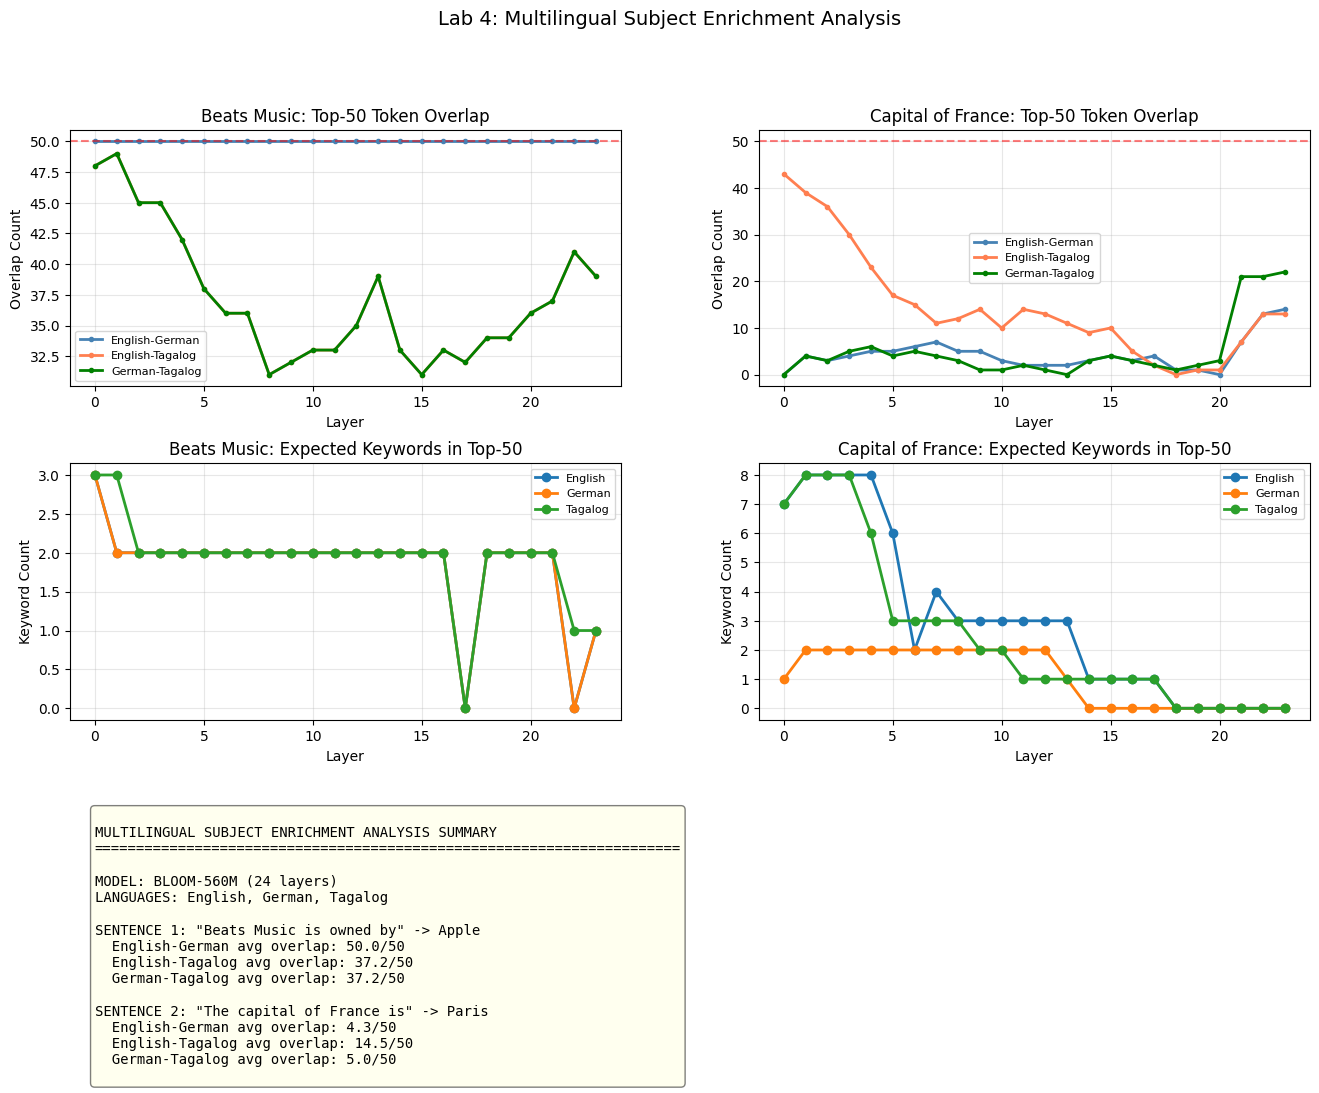

In [18]:
# Save comprehensive summary plot
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.25)
colors = ['steelblue', 'coral', 'green']

# 1. Beats Music - Token overlap by layer
ax1 = fig.add_subplot(gs[0, 0])
for i, (pair, data) in enumerate(overlap_beats.items()):
    ax1.plot(range(model.cfg.n_layers), data['overlaps'], 'o-', color=colors[i], 
             linewidth=2, markersize=3, label=pair)
ax1.axhline(y=50, color='red', linestyle='--', alpha=0.5)
ax1.set_xlabel('Layer')
ax1.set_ylabel('Overlap Count')
ax1.set_title('Beats Music: Top-50 Token Overlap')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# 2. Paris - Token overlap by layer
ax2 = fig.add_subplot(gs[0, 1])
for i, (pair, data) in enumerate(overlap_paris.items()):
    ax2.plot(range(model.cfg.n_layers), data['overlaps'], 'o-', color=colors[i], 
             linewidth=2, markersize=3, label=pair)
ax2.axhline(y=50, color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Layer')
ax2.set_ylabel('Overlap Count')
ax2.set_title('Capital of France: Top-50 Token Overlap')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

# 3. Beats Music - Keyword enrichment
ax3 = fig.add_subplot(gs[1, 0])
for lang, counts in keyword_counts_beats.items():
    ax3.plot(range(model.cfg.n_layers), counts, 'o-', label=lang, linewidth=2)
ax3.set_xlabel('Layer')
ax3.set_ylabel('Keyword Count')
ax3.set_title('Beats Music: Expected Keywords in Top-50')
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

# 4. Paris - Keyword enrichment
ax4 = fig.add_subplot(gs[1, 1])
for lang, counts in keyword_counts_paris.items():
    ax4.plot(range(model.cfg.n_layers), counts, 'o-', label=lang, linewidth=2)
ax4.set_xlabel('Layer')
ax4.set_ylabel('Keyword Count')
ax4.set_title('Capital of France: Expected Keywords in Top-50')
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3)

# 5. Summary text
ax5 = fig.add_subplot(gs[2, :])
ax5.axis('off')

# Compute summary stats
beats_avg = {pair: data['overlaps'].mean() for pair, data in overlap_beats.items()}
paris_avg = {pair: data['overlaps'].mean() for pair, data in overlap_paris.items()}

summary_text = f"""
MULTILINGUAL SUBJECT ENRICHMENT ANALYSIS SUMMARY
{'='*70}

MODEL: BLOOM-560M ({model.cfg.n_layers} layers)
LANGUAGES: English, German, Tagalog

SENTENCE 1: "Beats Music is owned by" -> Apple
  English-German avg overlap: {beats_avg.get('English-German', 0):.1f}/50
  English-Tagalog avg overlap: {beats_avg.get('English-Tagalog', 0):.1f}/50
  German-Tagalog avg overlap: {beats_avg.get('German-Tagalog', 0):.1f}/50

SENTENCE 2: "The capital of France is" -> Paris
  English-German avg overlap: {paris_avg.get('English-German', 0):.1f}/50
  English-Tagalog avg overlap: {paris_avg.get('English-Tagalog', 0):.1f}/50
  German-Tagalog avg overlap: {paris_avg.get('German-Tagalog', 0):.1f}/50
"""

ax5.text(0.02, 0.95, summary_text, transform=ax5.transAxes, fontsize=10, verticalalignment='top',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))

plt.suptitle('Lab 4: Multilingual Subject Enrichment Analysis', fontsize=14, y=0.98)
plt.savefig('lab4_plots/comprehensive_summary.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Save Results for Further Analysis

In [ ]:
# Save detailed results
import json as json_module

results = {
    'model': 'bloom-560m',
    'languages': ['English', 'German', 'Tagalog'],
    'sentences': {
        'beats': {
            'prompts': prompts_beats,
            'subject_positions': subject_pos_beats,
            'expected': 'Apple'
        },
        'paris': {
            'prompts': prompts_paris,
            'subject_positions': subject_pos_paris,
            'expected': 'Paris'
        }
    },
    'overlaps': {
        'beats': {pair: {'overlaps': data['overlaps'].tolist(), 'jaccard': data['jaccard'].tolist()} 
                  for pair, data in overlap_beats.items()},
        'paris': {pair: {'overlaps': data['overlaps'].tolist(), 'jaccard': data['jaccard'].tolist()} 
                  for pair, data in overlap_paris.items()}
    },
    'keyword_counts': {
        'beats': {lang: counts.tolist() for lang, counts in keyword_counts_beats.items()},
        'paris': {lang: counts.tolist() for lang, counts in keyword_counts_paris.items()}
    }
}

with open('lab4_plots/results.json', 'w') as f:
    json_module.dump(results, f, indent=2)

print("Results saved to lab4_plots/results.json")